# The motion of intermediate-mass black holes (IMBHs)

Task: 
   1. Locate (if present) the black hole of intermediate mass (IMBH) in each simulation. 
   2. Calculate centre of mass (COM) of the simulation.
   3. Determine the x,y,z components of the distance from the COM of the simulation.
   4. Graph the temporal evolution and the distribution over all times for a given simulation.
        - e.g. by plotting a histogram, measuring the standard deviation, skewness and kurtosis (within each simulation).
   5. Discuss the statistical significance of the results and any strategies to improve it.

## Contents:

Dataset structure and initial investigations.

Introduction - General information about IMBHs. 

Evolution of the mass in each simulation. Number of particles in the simulation over time. 

Motion of the Centre of Mass in simulations. 

Identify possible IMBH as particle with largest mass at final time.

Graphing motion relative to COM of the IMBH candidate. 

Conclusion - Statistical significance of results and possible improvements.

## Introduction

### What is an IMBH?

An Intermediate Massive Black Hole is a black hole (BH) with a mass approximately in the range $10^2 - 10^5 M_\odot$. 

### Why "intermediate"?

There are other types of BH.

Stellar-mass Black Holes are BHs with masses in the range $8 - 100 M_\odot$, the same magnitude as the mass of stars. They are formed by the hyperdense core of dead stars. There are different methods which have been successfully used to detect the existence of this kind of BH: kinematic effects, electromagnetic observations and gravitational wave detections. This kind of BH is the most commonly observed because of the way they are formed.

Super Massive Black Holes (SMBH) are BHs of mass $M>10^5 M_\odot$. Their method of formation is still unknown, but it is theorised that they have origins in the beginnings of the universe. Although there are not as many SMBHs as other types, they can be more easily detected because of their huge mass. Methods include X-ray detections or kinematic observations.  Recently, an optical image of the SMBH in the centre of the galaxy "M-87" was taken.

The mass range of IMBHs is between these two categories, as such they can be considered as the link between SMBHs and stellar-mass BHs.

### Do IMBHs really exist?

So far, there is no unambiguous evidence for the existence of IMBHs. Some electromagnetic observations have hinted the presence of IMBHs$^{[1][2][3]}$, but the results are not conclusive. The reason behind this uncertainty is the lack of detectors and techniques sensitive enough for measuring effect on the required scale. This has led to increased global interest from reasearchers on this topic$^{[4][5][6]}$. In the coming years, detectors such as GAIA will be able to verify if, or not, IMBHs exist.

### Why attempt detection of IMBHs?

An important consequence of the discovery of an IMBH is that it could deepen our understanding of cosmological dynamics and SMBHs. In theory, there could be a population of electromagnetically invisible IMBHs which could further explain the formation mechanism of SMBH.

### What is the origin of IMBHs?

The origin of IMBHs is still uncertain. We can exclude the theory that IMBHs are formed from the inert core of a star, as is the case for stellar-mass BHs, because no stars of sufficient mass have been detected$^{[7]}$. Stellar mass range is $0.1-100 M_\odot$, so a very massive star could possibly form a very light IMBH. For heavier IMBHs, another explanation must be found.

There are three main hypothesis$^{[8]}$: the first is that IMBHs have a cosmological origin, as an intermediate step towards the formation of SMBHs; the second is that they are the result of the merging of multiple massive stellar-mass BHs; the third is that they were formed by the remnants of very massive stars, the first generation of stars (Population III stars).

### Where are IMBHs likely to be found?

There are several candidates for IMBHs in different types of cosmic structures. In **[2]**, the authors suggested the presence of an IMBH in a spiral galaxy, while in **[1]**, a potential IMBH has been spotted in a globular cluster, and in **[3]** the candidate can be found inside a lenticular galaxy. Scientists believe they are widespread throughout the cosmos, the challenge is in detecting them.

In [1]:
from useful import *
%matplotlib inline

#useful variables
colors = ["royalblue", "firebrick"]
corrected_dataset = False

seed = "blackhole"
np.random.seed(np.sum([ord(c) for c in seed]))

## The dataset

### Project structure

We were provided two N-Body simulations, placed in two respective folders.
Each simulation is composed of several text files containing snapshots of the simulation. Thus, each simulation is constituted of files that correspond to its time evolution.

In [2]:
#relative locations of each dataset
pathname_1 = '../1/'
pathname_2 = '../2/'

#creating an array of filenames to iterate over.
filenames_1 = np.loadtxt(pathname_1+'filename.dat', dtype = str)
filenames_1 = np.array([pathname_1+i for i in filenames_1 if os.path.isfile(pathname_1+i)==True])
filenames_2 = np.loadtxt(pathname_2+'filename.dat', dtype = str)
filenames_2 = np.array([pathname_2+i for i in filenames_2 if os.path.isfile(pathname_2+i)==True])

Each snapshot presents a grid of entries. The components of position, velocity directions, mass and index of the particles are stored in corresponding columns. The index is an integer which allows to identify each particle in the simulation. Each row represents a particle of the simulation.

The units of measure used in the simulation are the N-BODY units: the total mass of the system and the virial radius are normalized to $1$. Because of this fact, we just have a scale factor and we don't know anything about the dimensions and the mass of the system in SI.

The time is measured in mega-years.

### Dataset into variables

We chose to store our dataset into `pandas.DataFrame` because:
- some built-in routines in `pandas` module compute faster than in `numpy`
- `pandas` is required to work with `seaborn`
- `pandas.DataFrame` allow using a more readable syntax, when slicing along columns or indices

We chose to use a `MultiIndex` to index our simulations. As first level of the index we put the epoch, so that each time snapshot of the simulation corresponds to a specific value in the first index. As second level of the index, we put the index of the particle, so that the trajectory of a particle corresponds to a specific value in the second index.

In [3]:
simulation_1 = simulation_to_pandas(filenames_1)
simulation_2 = simulation_to_pandas(filenames_2)

simulation_1

Loading database
Loading complete

Loading database
Loading complete



x          y          z        vx        vy        vz  \
t      idx                                                                     
0.0    1.0      0.034890  -0.063926  -0.206574 -0.539871 -0.631123 -1.039587   
       2.0      0.042413  -0.080144   0.234427 -0.278229 -0.535505  1.050878   
       3.0     -1.099345   0.874376   0.283639  0.236003  0.658489 -0.153412   
       4.0     -0.008523   0.051145   0.207674 -0.269871  0.806241  0.543916   
       5.0     -0.224274  -0.712615   0.646594  0.326479  0.488394 -0.127882   
...                  ...        ...        ...       ...       ...       ...   
4992.0 31996.0  1.305747  32.576878  30.624529 -0.148412 -0.015964 -0.250068   
       31997.0  1.446948  29.037743  35.741730 -0.041182 -0.046502 -0.593227   
       31998.0  1.814347  30.996538  32.299030  0.036295  0.026886  0.110373   
       31999.0 -5.655244  40.132893  28.773527 -0.077781  0.074813 -0.049089   
       32000.0  1.616896  30.226627  33.283588 -0.317683 -0.089222  0.179668   

                       m      idx       t  
t      idx                                 
0.0    1.0      0.000797      1.0     0.0  
       2.0      0.000767      2.0     0.0  
       3.0      0.000741      3.0     0.0  
       4.0      0.000717      4.0     0.0  
       5.0      0.000695      5.0     0.0  
...                  ...      ...     ...  
4992.0 31996.0  0.000016  31996.0  4992.0  
       31997.0  0.000016  31997.0  4992.0  
       31998.0  0.000016  31998.0  4992.0  
       31999.0  0.000016  31999.0  4992.0  
       32000.0  0.000016  32000.0  4992.0  

[10889715 rows x 9 columns]

To simplify syntax in the code, time and index were redundantly kept as columns in the dataframe and indexes of each entry.

### The dataset at a first glance

First of all we notice that the two simulations have similar time range and slightly different time sampling, and both contains $32000$ particles.

In [4]:
timestamps_1 = get_times(simulation_1)
print('Time of simulation 1: '+str(timestamps_1[0])+' <= t <= '+str(timestamps_1[-1]))
print('Number of Time-Snapshots in simulation 1:', timestamps_1.size)
print('Number of particles in simulation 1:', get_idx(simulation_1).size)
print()
timestamps_2 = get_times(simulation_2)
print('Time of simulation 2: '+str(timestamps_2[0])+' <= t <= '+str(timestamps_2[-1]))
print('Number of Time-Snapshots in simulation 2:', timestamps_2.size)
print('Number of particles in simulation 2:', get_idx(simulation_2).size)

Time of simulation 1: 0.0 <= t <= 4992.0
Number of Time-Snapshots in simulation 1: 346
Number of particles in simulation 1: 32000

Time of simulation 2: 0.0 <= t <= 4990.0
Number of Time-Snapshots in simulation 2: 351
Number of particles in simulation 2: 32000


To get an idea of the initial conditions in each simulation, we plot the position distribution of all particles in the first snapshot of each simulation.

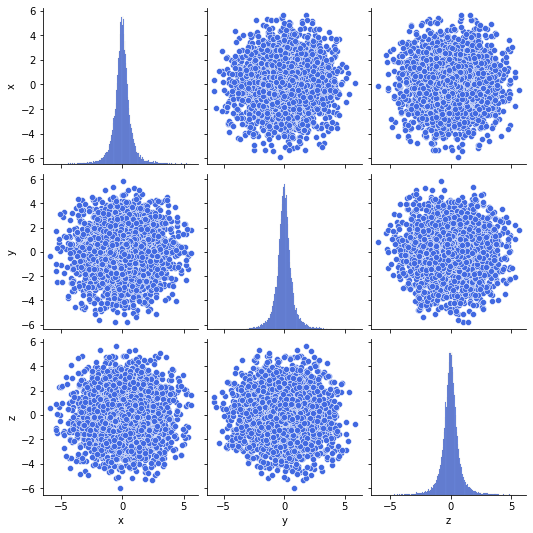

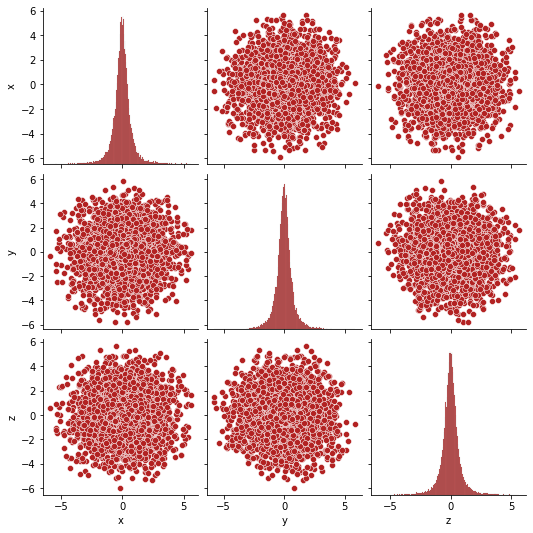

In [5]:
sns.pairplot(simulation_1.loc[0][["x", "y", "z"]], plot_kws={"color": colors[0]}, diag_kws={"color": colors[0]})

sns.pairplot(simulation_2.loc[0][["x", "y", "z"]], plot_kws={"color": colors[1]}, diag_kws={"color": colors[1]})

We can notice that the particles have initial position normally distributed around 0, with same dispersion along the three axis. We notice that the shapes of our clusters are spherical, both with reduced radius $\sim5$.

We look also at the time evolution of the cluster, plotting the position of the particles at the beginning, halfway and at the end of the simulation. We consider only the $xy$-plane because as seen in the plots above, the spherical symmetry should cause the behaviour along the $z$ coordinate to be consistent with the others'.

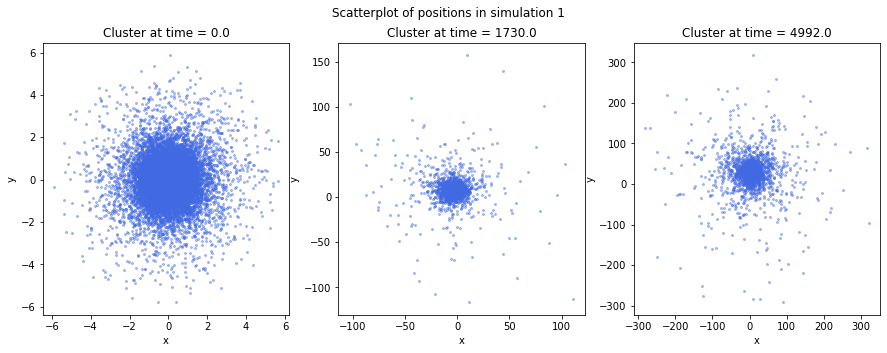

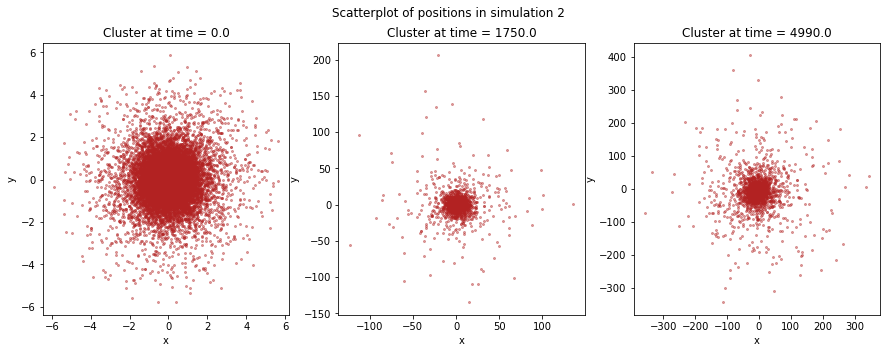

In [6]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
times = [timestamps_1[0], timestamps_1[timestamps_1.size//2], timestamps_1[-1]]
for i,t in enumerate(times):
    axs[i].scatter(simulation_1.loc[t]["x"], simulation_1.loc[t]["y"], color=colors[0], alpha=0.4, s=4)
    axs[i].set_title("Cluster at time = "+str(t))
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("y")
fig.suptitle("Scatterplot of positions in simulation 1")
plt.show()

fig, axs = plt.subplots(1,3, figsize=(15,5))
times = [timestamps_2[0], timestamps_2[timestamps_2.size//2], timestamps_2[-1]]
for i,t in enumerate(times):
    axs[i].scatter(simulation_2.loc[t]["x"], simulation_2.loc[t]["y"], color=colors[1], alpha=0.4, s=4)
    axs[i].set_title("Cluster at time = "+str(t))
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("y")
fig.suptitle("Scatterplot of positions in simulation 2")
plt.show()

The cluster boundaries increase as the simulation evolves in time. We can observe that the cluster maintains approximately a spherical shape, but some particles are much farther from the centre than at the beginning.

Comparing the initial positions (time $= 0.0$) of the particles in the two simulations, it seems that they are equal, possibly differing by just a slight perturbation. By printing out the position of each particle, it is possible to see that they are indeed slightly different (usually at the second-third digit). Probably the two simulations where produced with the same initial conditions adding some small random noise, which, in a unstable system, lead to substantially different evolutions in terms of the individual particles, but not necessarily of the simulation as an entire statistical system.

It's important to check the mass distribution of the particles at the beginning of the simulation.

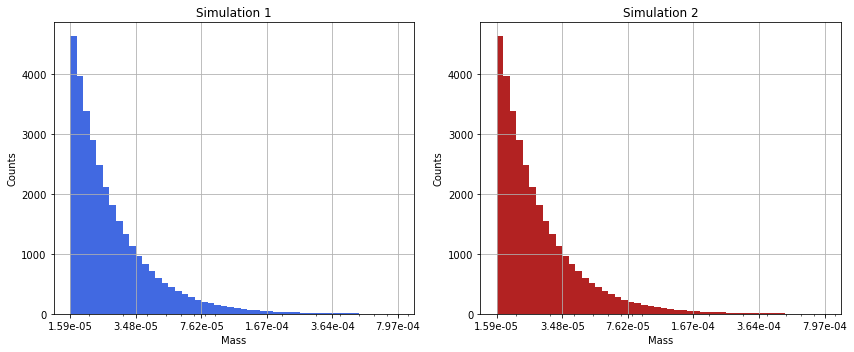

In [7]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
masses = [simulation_1.loc[0]["m"], simulation_2.loc[0]["m"]]
for i,ax in enumerate(axs):
    masses[i].hist(bins=np.logspace(np.log10(masses[i].min()), np.log10(masses[i].max()), 51), color=colors[i], ax=ax)
    ax.set_title("Simulation "+str(i+1))
    ax.set_xlabel("Mass")
    ax.set_ylabel("Counts")
    ax.set_xscale("log")
    ax.set_xticks(np.logspace(np.log10(masses[i].min()), np.log10(masses[i].max()), 6))
    ax.set_xticklabels(np.logspace(np.log10(masses[i].min()), np.log10(masses[i].max()), 6))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
fig.tight_layout()

From these histograms, we can conclude that:
- the two simulationshave the same particles;
- particles with lower mass are more common than particles with larger mass;
- the mass of the most massive particle is about 50 times larger than the mass of the least massive one.

### The physical meaning

All the considerations done so far are intended to understand what is the physical entity hidden behind this simulation. The hints are:
- the cluster has spherical symmetry
- it is composed of $O(10^4)$ particles
- all the particles have comparable mass (at most differences of one magnitude or two)
- it has a gaussian density profile
- the small difference in the initial positions suggest some kind of instability

Considering that we are looking for an IMBH, it looks reasonable to suppose that this simulation can represent a globular cluster. In fact, such structure has all the features mentioned above, and the detection of a IMBH in globular clusters is a research topic (as seen in **[1]**).

The evolution of particles (stars and others) in a globular cluster is knowingly chaotic, implying a tendency to instability. This could fairly explain the reason for the motivaton of fine-tuning the initial conditions discussed above.

If the simulation is really a globular cluster, there is the possibility that the instability of the system could lead to the ejection of some of its particles.

In [8]:
initial, final = get_idx(simulation_1).size, get_idx(simulation_1.loc[timestamps_1[-1]]).size
print('Initial number particles in simulation 1:', initial)
print('Final number particles in simulation 1:', final)
print(f'Percentage decrease in number of particles of simulation 1: {round((initial-final)/initial*100, 3)}%')
print()
initial, final = get_idx(simulation_2).size, get_idx(simulation_2.loc[timestamps_2[-1]]).size
print('Initial number particles in simulation 2:', initial)
print('Final number particles in simulation 2:', final)
print(f'Percentage decrease in number of particles of simulation 2: {round((initial-final)/initial*100, 3)}%')

Initial number particles in simulation 1: 32000
Final number particles in simulation 1: 30753
Percentage decrease in number of particles of simulation 1: 3.897%

Initial number particles in simulation 2: 32000
Final number particles in simulation 2: 30653
Percentage decrease in number of particles of simulation 2: 4.209%


The possibility of the ejection of some particles actually realises. This means that we need to investigate further the behaviour of the particles and the mass in the system, before going on with other computations.

While investigating this properties of the system, several anomalies in the datasets have been found. 

## Evolution of the mass and number of particles, discussing errors in the dataset

We now study how the total mass and the total number of particles in the simulation evolve in time.

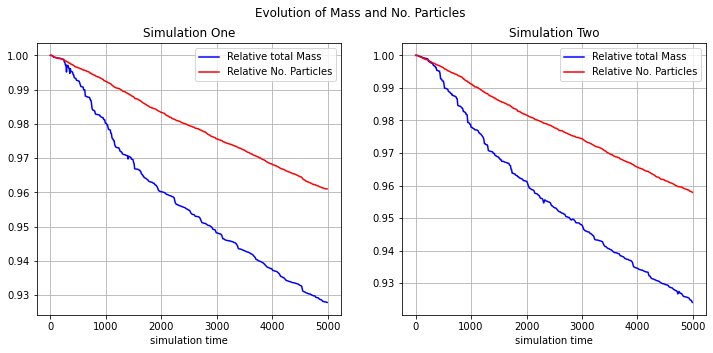

In [9]:
def mass_and_number_evolution(dataset):
    relevant_ds = dataset[["m"]]                        # extract mass column from dataset (as DataFrame)
    relevant_ds.insert(1,"n", 1)                        # append constant column of value 1
    m_and_n_evolution = relevant_ds.groupby("t").sum()  # sums values grouped by time

    max_n = len(relevant_ds.loc[0])                     # number of particles in snapshot 1

    del(relevant_ds)
    
    return m_and_n_evolution["m"],m_and_n_evolution["n"]


mass_evolution_1, number_evolution_1 = mass_and_number_evolution(simulation_1)
mass_evolution_2, number_evolution_2 = mass_and_number_evolution(simulation_2)

    
# plot
plt.figure(figsize= [12,5])

plt.suptitle('Evolution of Mass and No. Particles')
    
plt.subplot(121)
plt.title('Simulation One')
plt.plot(timestamps_1,mass_evolution_1,                         'b-', label='Relative total Mass')
plt.plot(timestamps_1,number_evolution_1/number_evolution_1[0], 'r-', label='Relative No. Particles')
plt.xlabel("simulation time")
plt.grid(True)
plt.legend()
    
plt.subplot(122)
plt.title('Simulation Two')
plt.plot(timestamps_2,mass_evolution_2,                         'b-', label='Relative total Mass')
plt.plot(timestamps_2,number_evolution_2/number_evolution_2[0], 'r-', label='Relative No. Particles')
plt.xlabel("simulation time")
plt.grid(True)
plt.legend()


plt.show()

By looking at the mass and number of particle plots we can make some observations:

   1. Mass is not constant over the simulation. It decreases almost linearly with time. 
   2. Particle number is not constant. Particles are ejected/vanished/destroyed.
   3. At some isolated times some unexpected increases of the total mass and/or the total number of particles are observed in both simulations.

### How can the mass (and no. of particles) increase?

We now focus on studying the "anomalous behaviour" detected in point 3.

In [10]:
# computes variation in total m and n (assigns to previous time index), drop last nan value, round numerical error values to zero
mass_variations_1   = (   mass_evolution_1.shift(-1) -   mass_evolution_1 ).drop(index=timestamps_1[-1]).round(14)
number_variations_1 = ( number_evolution_1.shift(-1) - number_evolution_1 ).drop(index=timestamps_1[-1]).round(14)
mass_variations_2   = (   mass_evolution_2.shift(-1) -   mass_evolution_2 ).drop(index=timestamps_2[-1]).round(14)
number_variations_2 = ( number_evolution_2.shift(-1) - number_evolution_2 ).drop(index=timestamps_2[-1]).round(14)

# extract time indexes of increments
# m
increasing_m_times_1 = (mass_variations_1[mass_variations_1>0]).index.tolist()
increasing_m_times_2 = (mass_variations_2[mass_variations_2>0]).index.tolist()
# n
increasing_n_times_1 = (number_variations_1[number_variations_1>0]).index.tolist()
increasing_n_times_2 = (number_variations_2[number_variations_2>0]).index.tolist()

#display
print("Increments in mass:\n")
display_side_by_side(pd.DataFrame(mass_variations_1.loc[increasing_m_times_1]),pd.DataFrame(mass_variations_2.loc[increasing_m_times_2]))
print("\nIncrements in number:\n")
display_side_by_side(pd.DataFrame(number_variations_1.loc[increasing_n_times_1]),pd.DataFrame(number_variations_2.loc[increasing_n_times_2]))


Increments in mass:



,m
t,
290.0,0.001970
350.0,0.001360
1400.0,0.000822
,m
t,
2310.0,0.000966
2810.0,0.000288
4730.0,0.000759



Increments in number:



,n
t,
350.0,1.0
,n
t,


We now look for the possible reasons of this anomalous behaviour.

#### Are particles allowed to change mass?
First we check wether a single particle is allowed to change its mass during the evolution.

In [11]:
def absolute_sum_of_single_particle_mass_variation(dataset):
    relevant_ds = dataset[["m"]]                       # extract the mass values from dataset
    GB = relevant_ds.groupby("idx")                    # group by index (each group is a trajectory)
    variation = (GB.max()-GB.min()).sum().tolist()[0]  # computes the absolute interval of mass visited by each particle, and cumulates
    del relevant_ds, GB                                   # clears memory
    return variation

print("Absolute sum of single particle mass variation:")
print(f"sim 1  -->  {absolute_sum_of_single_particle_mass_variation(simulation_1)}")
print(f"sim 2  -->  {absolute_sum_of_single_particle_mass_variation(simulation_2)}")

Absolute sum of single particle mass variation:
sim 1  -->  0.0
sim 2  -->  0.00033723163999999995


This means that in the first simulation there is no change in mass in any particle, while in the second there is some change of mass.
Further investigation into the origin of this mass change tracks it back to a sudden almost doubling of mass in particle $66$, which is halved again in a couple of time steps.

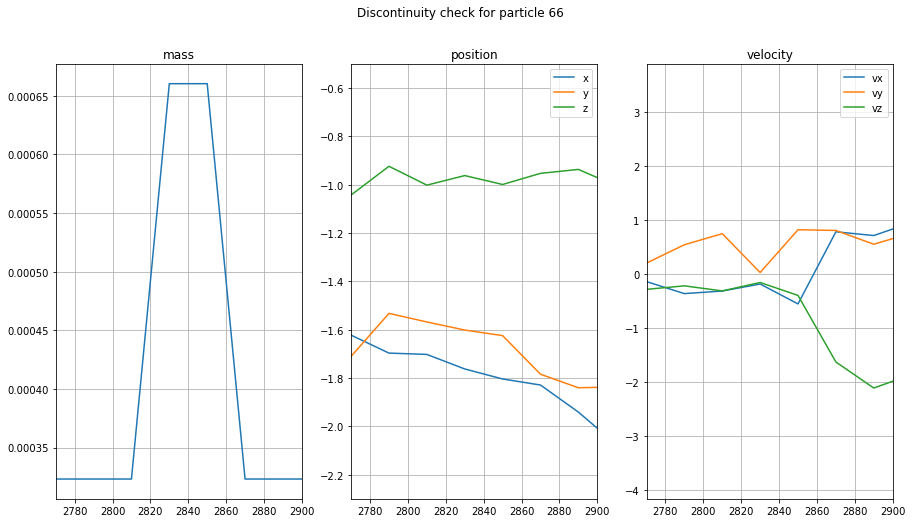

In [12]:
strange_particle = 66
time = trajectory(simulation_2,strange_particle,"t")

plt.figure(figsize=[15,8])

plt.suptitle("Discontinuity check for particle 66")

plt.subplot(131)
plt.title("mass")
plt.plot(time,trajectory(simulation_2,strange_particle,"m"))
plt.grid(True)
plt.xlim([2770,2900])

plt.subplot(132)
plt.title("position")
plt.plot(time,trajectory(simulation_2,strange_particle,"x"))
plt.plot(time,trajectory(simulation_2,strange_particle,"y"))
plt.plot(time,trajectory(simulation_2,strange_particle,"z"))
plt.grid(True)
plt.xlim([2770,2900])
plt.ylim([-2.3,-0.5])
plt.legend(["x","y","z"])
plt.xlabel("")

plt.subplot(133)
plt.title("velocity")
plt.plot(time,trajectory(simulation_2,strange_particle,"vx"))
plt.plot(time,trajectory(simulation_2,strange_particle,"vy"))
plt.plot(time,trajectory(simulation_2,strange_particle,"vz"))
plt.grid(True)
plt.xlim([2770,2900])
plt.legend(["vx","vy","vz"])


plt.show()

Since the other quantities show no anomalous behaviour, we consider this to be an error in the dataset, and so we correct it.

In [13]:
### AAA ### Fix dataset

# "real" mass value
m0 = simulation_2["m"].loc[0,66]
# mask of mass anomaly
odd_mass_mask = simulation_2["m"].loc(axis=0)[pd.IndexSlice[:,66]] > m0
# indexes to be changed
Idx = simulation_2[["m"]].loc(axis=0)[pd.IndexSlice[:,66]][ odd_mass_mask ].index
# actuate change
simulation_2["m"].loc[Idx] = m0

del odd_mass_mask, Idx
_ = gc.collect()

### AAA ###

And from now on we assume that **each particle preserves its mass during the simulation**.

In [14]:
print("Absolute sum of single particle mass variation:")
print(f"sim 1  -->  {absolute_sum_of_single_particle_mass_variation(simulation_1)}")
print(f"sim 2  -->  {absolute_sum_of_single_particle_mass_variation(simulation_2)}")

Absolute sum of single particle mass variation:
sim 1  -->  0.0
sim 2  -->  0.0


While this problemm in the dataset may in principle be responsable for one of the points of mass increments in simulation 2 it can not account for the others, nor can it be responsable for the ones in simulation one, so we look for other possibilities.

#### Are there new incoming particles?

A possibility that accounts for mass and particle increments is the existence of incoming particles.
In order to check if and how particles appear in the dataset, we check the minimal time associated to each particle index.

In [15]:
def comulated_particles_starting_times(dataset):
    groupby_index = dataset[["t"]].groupby("idx")     # extract list of times associated to each particle
    return groupby_index.min().sum().tolist()[0]      # sum over the minimum value of starting times for each particle


print(f"Comulated sum of particles starting times:")
print(f"sim 1  -->  {comulated_particles_starting_times(simulation_1)}")
print(f"sim 1  -->  {comulated_particles_starting_times(simulation_2)}")

Comulated sum of particles starting times:
sim 1  -->  0.0
sim 1  -->  0.0


Which means, given the fact that all times are bound to be positive, that every particle in the dataset starts at t=0 and there are no (new) incoming particles.

#### Can escaped particles come back?

Even if all particles starts at $t=0$, it may in principle be possible for an escaped particle to come back at a certain point.

We now check if it is possible for previously escaped particles to come back.
We enquire into this by looking for missing values in the time series asociated to each particle.

In [16]:
# takes a few seconds...
def find_missing_time(dataset,timestamps):
    groupby_index = dataset[["t"]].groupby("idx")                          # extract list of times associated to each particle
    group_operation = lambda group : group.max()-timestamps[len(group)-1]  # difference between timestamps value and expected time given the number of stamps
    missing_time = groupby_index.agg(group_operation)                      # agg applies function to each group 
    missing_time = missing_time[missing_time["t"]!=0]                      # filters for existing discrepancies
    return missing_time.rename(columns={"t":"missing_time"})

print("computing for sim 1...")
missing_time_1 = find_missing_time(simulation_1,timestamps_1)
print("computing for sim 2...")
missing_time_2 = find_missing_time(simulation_2,timestamps_2)

print("\n\nParticles with 'bubbles' in their time sequence:\n")
display_side_by_side(missing_time_1, missing_time_2)

computing for sim 1...
computing for sim 2...


Particles with 'bubbles' in their time sequence:



,missing_time
idx,
1.0,10.0
2.0,10.0
13.0,10.0
20.0,10.0
22.0,10.0
34.0,10.0
61.0,20.0
111.0,10.0
140.0,20.0


Here we can se the particle indexes with "bubbles" in their time sequence, and the corresponding time missing.

Since the missing times amount to single time steps we conclude that escaped particles do not come back and the source of the time jumps is once again to be ascribed to corruption in the dataset. We now look exactly at which time frames are missing and reinsert them by linearly interpolate the values of the previous and following points.

In order to find which time stamps are missing for a given particle, we compare the time sequence of a problematic particle with the time sequence of a particle which misses one frame at the beginning. At the beginnig this two sequences will be different but when the missing frame is reached the particle time sequence will collapse on the 'one missing' line. 

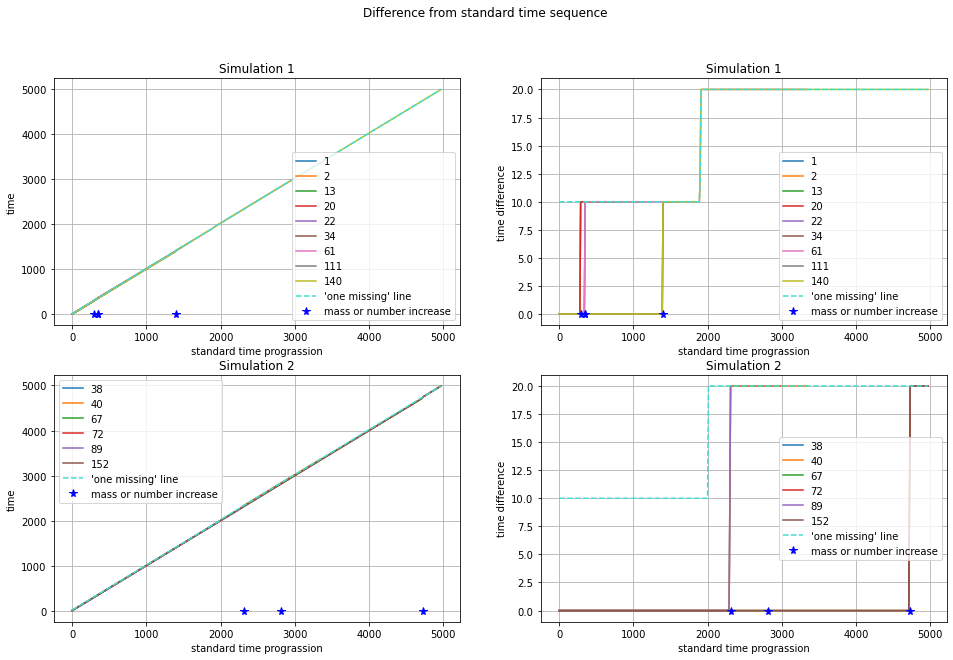

In [17]:
problematic_particles_1 = missing_time_1.index.to_numpy(dtype=int) # array of the indexes with anomalous trajectory
problematic_particles_2 = missing_time_2.index.to_numpy(dtype=int)

plt.figure(figsize=[16,10])

plt.suptitle("Difference from standard time sequence")

axsa_1 = plt.subplot(221)
axsb_1 = plt.subplot(222)
axsa_1.set_title("Simulation 1")
axsb_1.set_title("Simulation 1")
missing_times_1 = plot_time_differences(axsa_1,axsb_1,simulation_1,timestamps_1,problematic_particles_1,increasing_m_times_1,increasing_n_times_1)

axsa_2 = plt.subplot(223)
axsb_2 = plt.subplot(224)
axsa_2.set_title("Simulation 2")
axsb_2.set_title("Simulation 2")
missing_times_2 = plot_time_differences(axsa_2,axsb_2,simulation_2,timestamps_2,problematic_particles_2,increasing_m_times_2,increasing_n_times_2)

plt.show()

On the right plots we can observe where the missing frames of each particle are located in the simulation. When a particle line collapses on the dashed line a time frame is missing.

We observe that almost all anomalies in mass and number can be ascriben to missing time-frames. All exept one, which can instead be related to the "mass anomaly" previously studied and fixed.

We now fix the dataset reconstructing the missing time steps by interpolation.

#### Fixing the dataset

For each problematic particle in simulations 1 and 2 we found the following missing times:

In [18]:
missing_time_stamps_1 = compute_missing_times(simulation_1,timestamps_1,problematic_particles_1,increasing_m_times_1,increasing_n_times_1)
missing_time_stamps_2 = compute_missing_times(simulation_2,timestamps_2,problematic_particles_2,increasing_m_times_2,increasing_n_times_2)

print("Missing times from problematic particles:\n")
print("Sim 1:")
print(f"particles     --> {problematic_particles_1}")
print(f"missing times --> {missing_time_stamps_1}")
print("Sim 2:")
print(f"particles     --> {problematic_particles_2}")
print(f"missing times --> {missing_time_stamps_2}")

Missing times from problematic particles:

Sim 1:
particles     --> [  1   2  13  20  22  34  61 111 140]
missing times --> [290.0, 290.0, 350.0, 290.0, 350.0, 1400.0, 350.0, 1400.0, 1400.0]
Sim 2:
particles     --> [ 38  40  67  72  89 152]
missing times --> [2310.0, 2310.0, 4730.0, 4730.0, 2310.0, 4730.0]


We now reconstruct the missing data and append them to our dataset.

In [19]:
### AAA ### Fix dataset

if (corrected_dataset == False) :
    simulation_1 = simulation_1.append(missing_frames(simulation_1,problematic_particles_1,missing_time_stamps_1))
    simulation_2 = simulation_2.append(missing_frames(simulation_2,problematic_particles_2,missing_time_stamps_2))
    gc.collect()
    corrected_dataset = True

# resorting the datasets
simulation_1.sort_index(axis="index", inplace=True)
simulation_2.sort_index(axis="index", inplace=True)

### AAA ###

By observing the new mass and number evolution plot, we observe that the "kinks" previously present have now been removed.

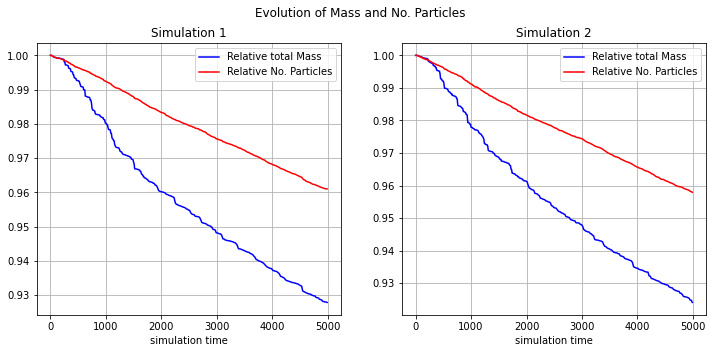

In [20]:
mass_evolution_1, number_evolution_1 = mass_and_number_evolution(simulation_1)
mass_evolution_2, number_evolution_2 = mass_and_number_evolution(simulation_2)
    
# plot
plt.figure(figsize= [12,5])

plt.suptitle('Evolution of Mass and No. Particles')
    
plt.subplot(121)
plt.title('Simulation 1')
plt.plot(timestamps_1,mass_evolution_1,                         'b-', label='Relative total Mass')
plt.plot(timestamps_1,number_evolution_1/number_evolution_1[0], 'r-', label='Relative No. Particles')
plt.xlabel("simulation time")
plt.grid(True)
plt.legend()
    
plt.subplot(122)
plt.title('Simulation 2')
plt.plot(timestamps_2,mass_evolution_2,                         'b-', label='Relative total Mass')
plt.plot(timestamps_2,number_evolution_2/number_evolution_2[0], 'r-', label='Relative No. Particles')
plt.xlabel("simulation time")
plt.grid(True)
plt.legend()

plt.show()

### Summing up: particles vanish and do npt come back

We have seen that each particle index preserves its mass during the simulation, and that no new indexes appear, terefore **there are no incoming particles, nor merging events**. We have seen that during the simulation particles are ejected, without coming back, as illustrated by the decreasing particle number with respect to time. 

### Why some particles vanish?

After fixing the datasets for the anomalous behaviour of some particles, we are left with an almost constant decrease in the number of particles and the mass of the system, which must be further investigated.

First of all, we select some particles among the ones who vanish and we plot their 3D trajectory to see what happens.

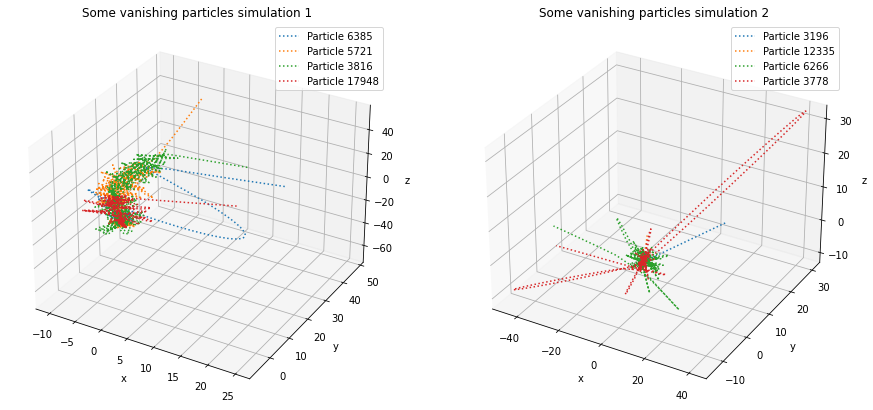

In [21]:
vanished_particles_1 = get_vanishing_particles(simulation_1)
vanished_particles_2 = get_vanishing_particles(simulation_2)

some_vanished_particles_1 = np.random.choice(vanished_particles_1, 4)
some_vanished_particles_2 = np.random.choice(vanished_particles_2, 4)

fig, axs = subplots3d(1, 2, figsize=(15,7))
path_plot3D(take_these_particles(simulation_1, some_vanished_particles_1), axs[0], "Some vanishing particles simulation 1")
path_plot3D(take_these_particles(simulation_2, some_vanished_particles_2), axs[1], "Some vanishing particles simulation 2")

del fig, axs
_ = gc.collect()

The trajectories of the disappearing particles finish with a straight line going out from the centre of the simulation. The physical meaning is that these particles, after making a scattering, they acquire enough kinetic energy to escape from the system. Once the simulation program computes an unbounded energy for some particles, it excludes them from the simulation.

It could be interesting to study what are the particles which escape from the simulation.

### Analysis of the ejected particles

We have seen that during the simulation some particles are ejected, we now look for correlation between mass of the particles and probability of ejection.

The distribution of the masses is definitely not uniform, so to get a meaningful result we divide the histogram of the masses of the ejected particles by the histogram of all the masses. In such a way, we obtain the frequency of ejected particles in each bin.

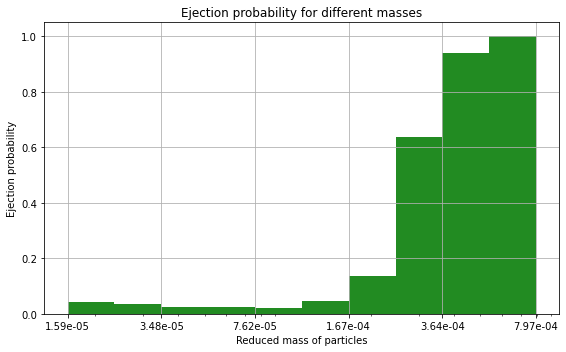

particles per bin:

ejected --> [1476  559  188   77   33   31   43   93   62   32]
initial --> [34746 15890  7266  3322  1520   696   316   146    66    32]


In [22]:
escaped_1 = take_these_particles(simulation_1, vanished_particles_1) # selects the data of the particles that escape fron the simulation
escaped_2 = take_these_particles(simulation_2, vanished_particles_2)

mmax = simulation_1["m"].loc[0].max()  # same for both datasets
mmin = simulation_1["m"].loc[0].min()
logbins = np.logspace(np.log10(mmin), np.log10(mmax), 11)

hist1_e, division = np.histogram(escaped_1["m"].loc[0], bins=logbins)
hist2_e, division = np.histogram(escaped_2["m"].loc[0], bins=logbins)
hist_e = hist1_e + hist2_e

hist1, division = np.histogram(simulation_1["m"].loc[0], bins=logbins)
hist2, division = np.histogram(simulation_2["m"].loc[0], bins=logbins)
hist = hist1+hist2

fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.set_title("Ejection probability for different masses")
ax.hist((logbins[1:]+logbins[:-1])/2,bins=logbins, weights=hist_e/hist, color='forestgreen', linestyle='-', linewidth=2)
ax.set_ylabel("Ejection probability")
ax.set_xlabel("Reduced mass of particles")
ax.set_xscale("log")
ax.set_xticks(np.logspace(np.log10(mmin), np.log10(mmax), 6))
ax.set_xticklabels(np.logspace(np.log10(mmin), np.log10(mmax), 6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
plt.grid(True)
fig.tight_layout()
plt.show()

print("particles per bin:\n")
print(f"ejected --> {hist_e}")
print(f"initial --> {hist}")

The data shows likelihood of ejection increases with increasing mass. We notice that ***all*** the most massive particles, in both simulations, are ejected.

## The centre of mass

To better understand the dynamics of the system, we attempt several different approaches to determine the coordinates and motion of the centre of mass.

The first approach is to compute the centre of mass in the standard way, obtaining its trajectory in the simulation.

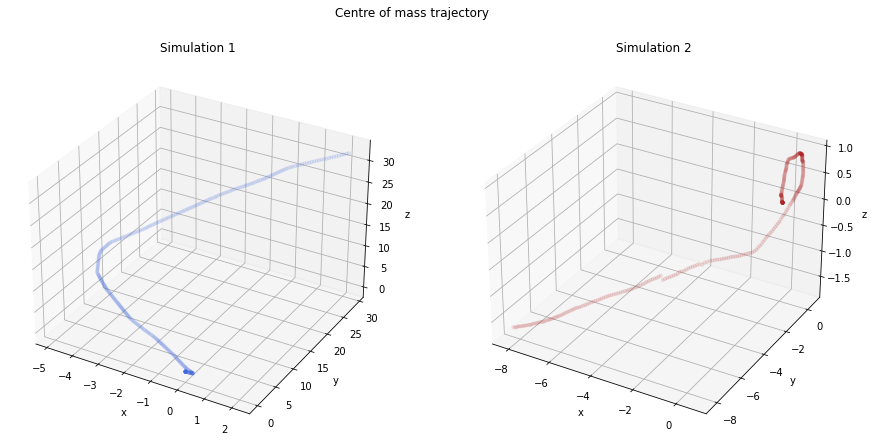

In [23]:
fig, axs = subplots3d(1,2, figsize=(15,7))

fig.suptitle("Centre of mass trajectory")

COM_1_trajectory = pd.concat([centre_of_mass(simulation_1.loc[t]) for t in timestamps_1])
axs[0].scatter(COM_1_trajectory["x"], COM_1_trajectory["y"], COM_1_trajectory["z"], color=colors[0], s=10, alpha=0.1)

COM_2_trajectory = pd.concat([centre_of_mass(simulation_2.loc[t]) for t in timestamps_2])
axs[1].scatter(COM_2_trajectory["x"], COM_2_trajectory["y"], COM_2_trajectory["z"], color=colors[1], s=10, alpha=0.1)

for i,ax in enumerate(axs):
    ax.set_title("Simulation "+str(i+1))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

We notice some anomalous behaviour in the motion of the centre of mass:
- it does not move as a free particle (changes direction).
- its trajectory is not smooth (there are some discontinuities and some angles).
- it speeds up as the simulation evolves (color intensity in the plot indicates how much time is passed in a given position: in darker areas, the center of mass is moving more slowly).

Since the function used to compute the centre of mass position is thought to be as computationally safe as possible, it is not likely that the anomalies are due to computational errors, also because of the range of the positions of the centre of mass is too big to be due to rounding errors. We must investigate the problem.

The cause of this global acceleration is to be ascribed to the recoil left in the system by the particles which are ejected into hyperbolic orbits and are therefore excluded from the simulation (as discussed above): when the particles disappear from the simulation, their momenta vanish too and the centre of mass suddently loses some of its momentum.

Hue density in the plot indicates the positions in which the centre of mass spends more time, and is therefore associated to lower speeds. We can observe that in the beginning the centre of mass is relatively still around the origin of the reference frame. As more mass is ejected form the system it acquires more and more momentum in random directions. We can observe that the trajectories shows an almost uniform motion with its direction changed by recoils, associated with particularly energetic ejection events.

#### Drop the ejected particles from the computation

In order to smooth the trajectory of the centre of mass, we extract the subset of all the particles which remain at the end of the simulation.

In [24]:
survived_1 = drop_these_particles(simulation_1, vanished_particles_1)
survived_2 = drop_these_particles(simulation_2, vanished_particles_2)

#### Compute the centre of mass over the core only

As the simulation evolves, some particles move very far away from the centre of the cluster, with trajectories that while seeming unbound, are not discarded by the simulation algorithm. When computing the centre of mass position, the farthest particles have greater weight, and this is not physically meaningful. In fact, the particles which interact the most are the ones in the core of the cluster, so it is important to study the time evolution of the core of the cluster.

We now plot the distribution of the positions of the particles along the $x$-axis (assuming a similar behavior in the $y$ and $z$ directions) at the beginning, in the middle, and at the end of the simulation.

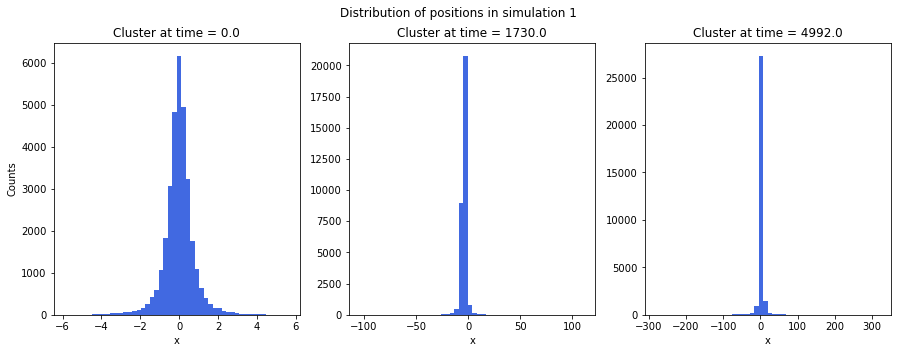

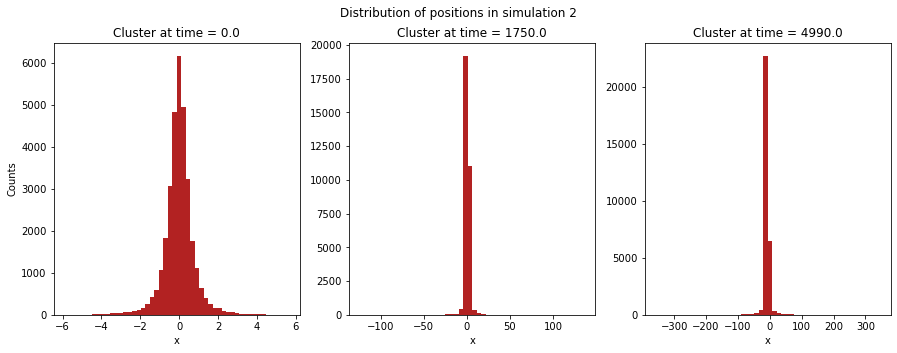

In [25]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
times = [timestamps_1[0], timestamps_1[timestamps_1.size//2], timestamps_1[-1]]
for i,t in enumerate(times):
    axs[i].hist(simulation_1.loc[t]["x"], bins=50, color=colors[0])
    axs[i].set_title("Cluster at time = "+str(t))
    axs[i].set_xlabel("x")
axs[0].set_ylabel("Counts")
fig.suptitle("Distribution of positions in simulation 1")
plt.show()

fig, axs = plt.subplots(1,3, figsize=(15,5))
times = [timestamps_2[0], timestamps_2[timestamps_2.size//2], timestamps_2[-1]]
for i,t in enumerate(times):
    axs[i].hist(simulation_2.loc[t]["x"], bins=50, color=colors[1])
    axs[i].set_title("Cluster at time = "+str(t))
    axs[i].set_xlabel("x")
axs[0].set_ylabel("Counts")
fig.suptitle("Distribution of positions in simulation 2")
plt.show()

The histograms show that the more the simulation evolves, the effect of the particles furthest from the centre of mass becomes increasingly pronounced. Thus, we adopt an iterative algorithm which computes the centre of mass in such a way:

1. compute the position of the centre of mass over all the particles
2. compute the distances of all the particles from that centre of mass
3. discard particles whose distance to the center of mass is above a decided relative threshold.
4. recompute the position of the centre of mass over those particles
5. iterate until the difference between two consecutive results falls below a certain sensitivity limit.

We show that this method can give reliable results plotting the distribution of the positions of the particles in the last time snapshot, varying the value of the threshold.

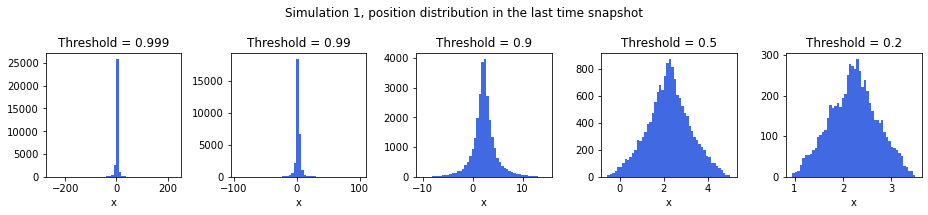

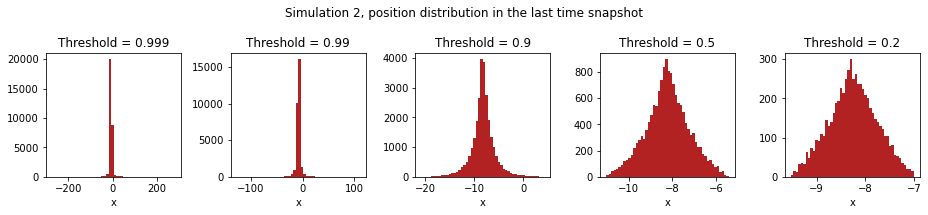

In [26]:
thresholds = np.array([0.999, 0.99, 0.9, 0.5, 0.2])

fig, axs = plt.subplots(1, len(thresholds), figsize=(13,3))
snap = simulation_1.loc[timestamps_1[-1]]
for i,ax in enumerate(axs):
    _, selection = iterative_COM_core(snap, thresholds[i])
    ax.hist(selection["x"], bins=50, color=colors[0])
    ax.set_xlabel("x")
    ax.set_title("Threshold = "+str(thresholds[i]))
fig.suptitle("Simulation 1, position distribution in the last time snapshot")
fig.tight_layout()

fig, axs = plt.subplots(1, len(thresholds), figsize=(13,3))
snap = simulation_2.loc[timestamps_2[-1]]
for i,ax in enumerate(axs):
    _, selection = iterative_COM_core(snap, thresholds[i])
    ax.hist(selection["x"], bins=50, color=colors[1])
    ax.set_xlabel("x")
    ax.set_title("Threshold = "+str(thresholds[i]))
fig.suptitle("Simulation 2, position distribution in the last time snapshot")
fig.tight_layout()

The distribution corresponding to the threshold $0.9$ seems to be the best one, because the long tails are cut but it still preserves a sort of gaussian shape. We will set the default value of the threshold to $0.9$.

We show a scatterplot of the last time snapshots in both simulations, enlighting the particles which are within the threshold.

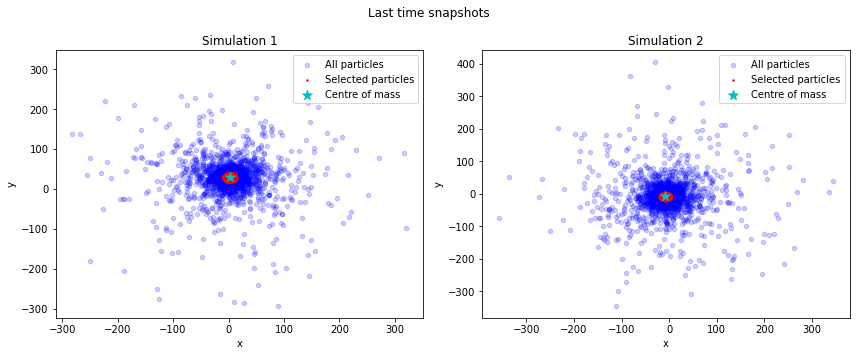

In [27]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

snap = simulation_1.loc[timestamps_1[-1]]
cm, selection = iterative_COM_core(snap)
axs[0].scatter(snap["x"], snap["y"], color='b', s=20, alpha=0.2, label="All particles")
axs[0].scatter(selection["x"], selection["y"], color='r', s=2, label="Selected particles")
axs[0].scatter(cm[-1,0], cm[-1,1], color='c', marker='*', s=100, label="Centre of mass")

snap = simulation_2.loc[timestamps_2[-1]]
cm, selection = iterative_COM_core(snap)
axs[1].scatter(snap["x"], snap["y"], color='b', s=20, alpha=0.2, label="All particles")
axs[1].scatter(selection["x"], selection["y"], color='r', s=2, label="Selected particles")
axs[1].scatter(cm[-1,0], cm[-1,1], color='c', marker='*', s=100, label="Centre of mass")

for i,ax in enumerate(axs):
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Simulation "+str(i+1))
    ax.legend()
fig.suptitle("Last time snapshots")
fig.tight_layout()

The final result for the trajectory of the centre of mass is the following.

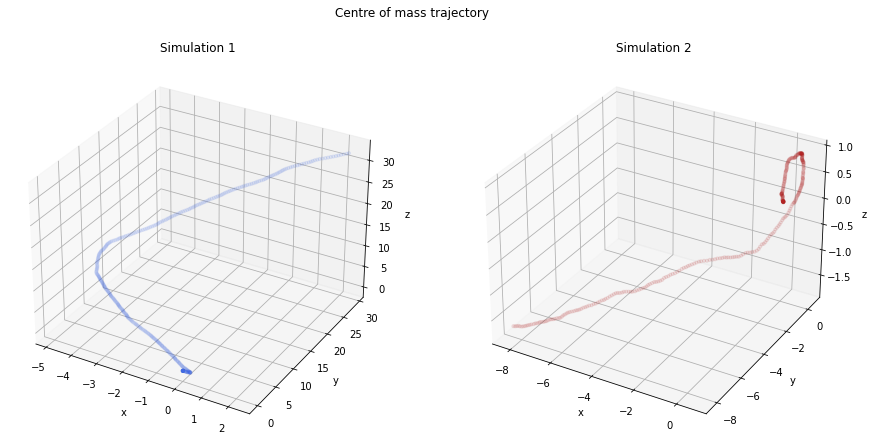

In [28]:
COM_1 = compute_COM(survived_1)
COM_2 = compute_COM(survived_2)

fig, axs = subplots3d(1,2, figsize=(15,7))

fig.suptitle("Centre of mass trajectory")

axs[0].scatter(COM_1["x"], COM_1["y"], COM_1["z"], color=colors[0], s=10, alpha=0.1)

axs[1].scatter(COM_2["x"], COM_2["y"], COM_2["z"], color=colors[1], s=10, alpha=0.1)

for i,ax in enumerate(axs):
    ax.set_title("Simulation "+str(i+1))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

Despite having excluded the ejected particles from the computation, there is still an evidence of their existence. Excluding those particles is equivalent to consider them as an "external perturbation", which plays the role of a random external force acting on the system, making it drift in a non-inertial way. We cannot remove this effect from the simulation, but at least we have a more meaningful computation of the centre of mass, as portrayed by the smoothing of the paths when compared to the earlier plots.

With this more sensible definition for the centre of mass, we may proceed to analyse the motion of the particles (and in particular of our IMBH candidate) in the centre of mass frame.

In [29]:
del survived_1, survived_2, escaped_1, escaped_2
_ = gc.collect()

## Analysis of relative position, velocities, and mass distribution

Given the demanding nature of the computation, we focus solely on the first simulation.

Initially, we compute the relative properties over the whole dataset (relative position and relative velocities).

Then we reinsert in the dataset the value of the masses, and for convenience we also compute the absolute distances of the particles from the centre of mass.

In [30]:
relative_1 = change_to_COM_frame(simulation_1, COM_1)

### Position and velocity distributions
We now study the distribution of the relative poitions and velocities over the whole evolution, to measure the extent of symmetry in the data, and the weight of the tails in each distribution through the measure of skewness and kurtosis.

In [31]:
coords = ['x', 'y', 'z']
directions = ['vx', 'vy', 'vz']

r1_stats_pos = pd.DataFrame({'Std. dev': relative_1[coords].std()    , 'Skewness' : relative_1[coords].skew()    , 'Kurtosis' : relative_1[coords].kurt()}    )
r1_stats_vel = pd.DataFrame({'Std. dev': relative_1[directions].std(), 'Skewness' : relative_1[directions].skew(), 'Kurtosis' : relative_1[directions].kurt()})

display_side_by_side(r1_stats_pos,r1_stats_vel)

,Std. dev,Skewness,Kurtosis
x,6.417750,0.036916,365.528296
y,6.328723,-5.114811,447.166295
z,6.139047,-0.769170,441.994772
,Std. dev,Skewness,Kurtosis
vx,0.317191,-0.002616,1.053372
vy,0.316861,0.003193,0.915024
vz,0.317496,0.063337,4.375132


As far as skewness is concerned, both distributions seem fairly symmetric. 

The kurtosis index instead is very different between the two. The position distributions seems to encompass a larger range, while the velocity distributions seem low and homogeneous.

We now plot the distributions explicitly.

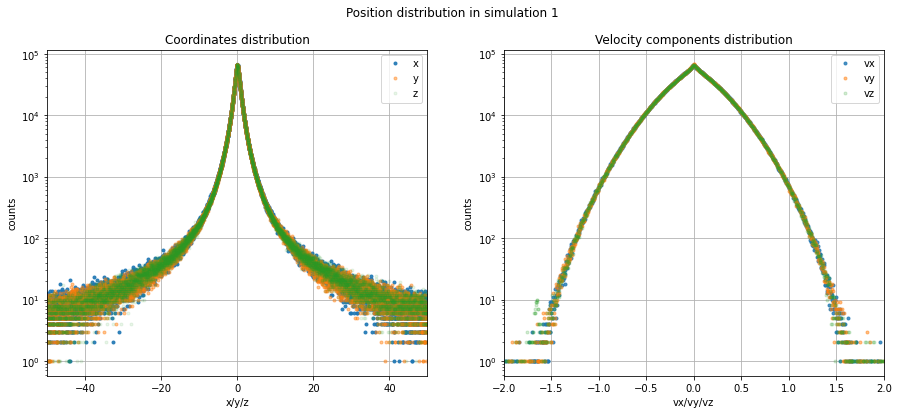

In [32]:
xcounts, xbins = np.histogram(relative_1['x'], bins = 'fd')
ycounts, ybins = np.histogram(relative_1['y'], bins = 'fd')
zcounts, zbins = np.histogram(relative_1['z'], bins = 'fd')

vxcounts, vxbins = np.histogram(relative_1['vx'], bins = 'fd')
vycounts, vybins = np.histogram(relative_1['vy'], bins = 'fd')
vzcounts, vzbins = np.histogram(relative_1['vz'], bins = 'fd')

fig = plt.figure( figsize = (15,6))

fig.suptitle('Position distribution in simulation 1')

axs = plt.subplot(121)
plt.title("Coordinates distribution")
plt.plot(0.5*(xbins[1:]+xbins[:-1]),xcounts,alpha=0.9,linestyle='',marker='.',label="x")
plt.plot(0.5*(ybins[1:]+ybins[:-1]),ycounts,alpha=0.45,linestyle='',marker='.',label="y")
plt.plot(0.5*(zbins[1:]+zbins[:-1]),zcounts,alpha=0.1,linestyle='',marker='.',label="z")
plt.xlabel('x/y/z')
plt.ylabel('counts')
plt.xlim([-50,50])
plt.yscale("log")
plt.legend()
plt.grid(True)

axs = plt.subplot(122)
plt.title("Velocity components distribution")
plt.plot(0.5*(vxbins[1:]+vxbins[:-1]),vxcounts,alpha=0.8,linestyle='',marker='.',label="vx")
plt.plot(0.5*(vybins[1:]+vybins[:-1]),vycounts,alpha=0.5,linestyle='',marker='.',label="vy")
plt.plot(0.5*(vzbins[1:]+vzbins[:-1]),vzcounts,alpha=0.2,linestyle='',marker='.',label="vz")
plt.xlabel('vx/vy/vz')
plt.ylabel('counts')
plt.xlim([-2,2])
plt.yscale("log")
plt.legend()
plt.grid(True)

plt.show()

First of all we notice that the distributions of the three coordinates are similar, further pointing to spherical symmetry in the system.

In agreement with the skewness and kurtosis indexes, both distributions are symmetric, but present a contrasting long range behaviour. For higher values, the velocity distribution is more similar to a reversed parabola, which is the log equivalent of a gaussian distribution. On the other hand, the position distribution tails are more similar to an inverse logarithm, pointing to a Lorentzian distribution.

### Density profile in the star cluster

We now study the density profile (mass over volume) of the cluster. Since we have seen that the cluster is highly symmetric, it makes sense to express such densities as radial functions.

We define a general profiling function. The profiling function proceeds by computing the 2D histogram of the dystance and the quantity of interest. By contraction over the quantity dimension it obtains the quantity profile of the cluster (how much of the quantity is preset in each bin of distance). By dividing the quantity profile by the proper volume element, the density of the quantity as a function of the radial distance from the COM is obtained.

We now apply our profiling function over distance and mass to obtaind the mass density profile.

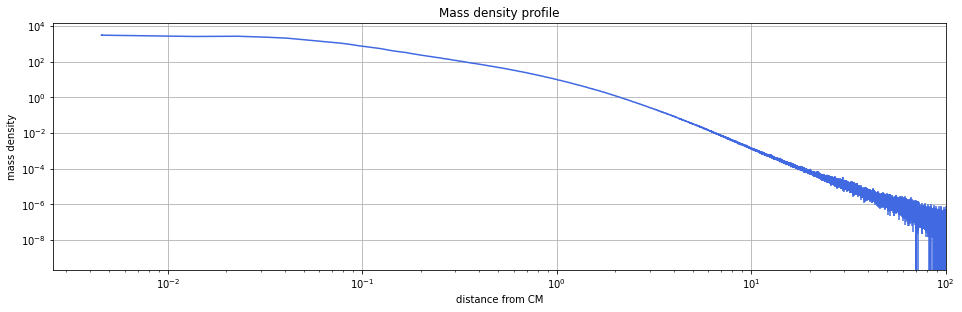

In [33]:
distance, mass_density, error_md  = density_profiling(relative_1["dist"], relative_1["m"] )

plt.figure(figsize=[16,10])

plt.subplot(211)
plt.title("Mass density profile")
plt.errorbar(distance, mass_density, error_md, color=colors[0])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("distance from CM")
plt.ylabel("mass density")
plt.xlim(right=10**2)
plt.grid(True)

plt.show()

As observed, mass density tends to flatten near the origin, decreasing significantly with increasing distance. In fact, the motion for any particle near the centre of mass can be decomposed into a central component and a random component. This is due to the fact that with increased density, collisions between particles become more prevalent than the usual gravitational component about the centre of mass. When under a certain distance from it, any particle will find the central force acting on it perturbed by neighbouring particles' own gravitational effects. Naturally, as density decreases and each particle has more space to move undisturbed, the central force gains relevance again. In this vein, we consider setting a threshold distance for which the density becomes essentially uniform, at $0.1$ units away from the centre of mass.

This could be interpreted as the threshold at which random motion starts to dominate over the global gravitation motion.

## IMBH candidate

The presence of a large number of low mass particles can suggest to identify them with low mass stars. Considering that the range of mass for stars has a lower and an upper bound which is wider than the range considered in this simulation, it is probable that the lightest particle in the simulation is a low mass star and the heaviest particle is a big star or a stellar mass black hole.

### Redefinition of our task

This is a problem since our task is to study the motion of a IMBH, which probably is not present in this cluster. In fact, if the most massive particle is a IMBH, then all the other particles should be very massive stars, which is not  plausible for any globular cluster.

In any case, we may study the motion of our most massive particles. However, the most massive particles are ejected at some point during the simulation, as seen in the likelihood histogram.

Moreover, some particles which do not meet the ejection criteria to be eliminated still end up far away from the system, presenting an unbound trajectory, and thus end up having no effect in the dynamics of the N-body system.

These aspects make it sensible to focus on ***the kinematics of the most massive particles that survive in the core of the clusters until the end of each simulation***.

### Studying the trajectories of the most massive particles

We choose the most massive particle remaining in the simulation as the "IMBH candidate" to be studied. The most massive particles in the initial snapshots, as we have previously observed, end up getting ejected over the course of the simulation. We observed that in the first simulation the two most massive particles remaining are "almost ejected", in the sense that they where kicked into very high orbits which permanence time is of the order of the duration of the simulation. For this reason we chose, for the first simulation only, to study the third most massive remaining particle.


First, we identify our IMBH cadidates. Then, we study their motion with respect to the center of mass.

In [34]:
def find_largest_mass(simulation, order=1):
    t = get_times(simulation).max()
    subdata = simulation.loc[t][["m"]]
    subdata.drop_duplicates(inplace=True)
    subdata.sort_values("m", ascending=False, inplace=True)
    return take_these_particles(simulation, subdata.index[order-1])

BH_candidate_1 = find_largest_mass(simulation_1, 3) # takes the third most massive particle
BH_candidate_2 = find_largest_mass(simulation_2)    # takes the most massive particle

Following the line of reasoning previously exposed, our IMBH candidates of choice end up being, in both simulations, particle 44.

We study the candidate's relative motion with respect to the cluster centre of mass. In order to do that, we compute the relative position vectors, velocities and the absolute distances from the centre of mass evolving over time.

In [35]:
rel_bh1 = BH_candidate_1.droplevel('idx')[['x','y','z','vx','vy','vz']] - COM_1    # compute relative properties
rel_bh1[ ['m','idx','t'] ]  = BH_candidate_1.droplevel('idx')[['m','idx','t']]     # add missing features
rel_bh1['distance'] = ((rel_bh1[['x','y','z']]**2).sum(axis=1)).transform(np.sqrt) # add absolute distance from cm for convenience

rel_bh2 = BH_candidate_2.droplevel('idx')[['x','y','z','vx','vy','vz']] - COM_2    # compute relative properties
rel_bh2[ ['m','idx','t'] ]  = BH_candidate_2.droplevel('idx')[['m','idx','t']]     # add missing features
rel_bh2['distance'] = ((rel_bh2[['x','y','z']]**2).sum(axis=1)).transform(np.sqrt) # add absolute distance from cm  for convenience

And plot the relative motion of the BH candidates:

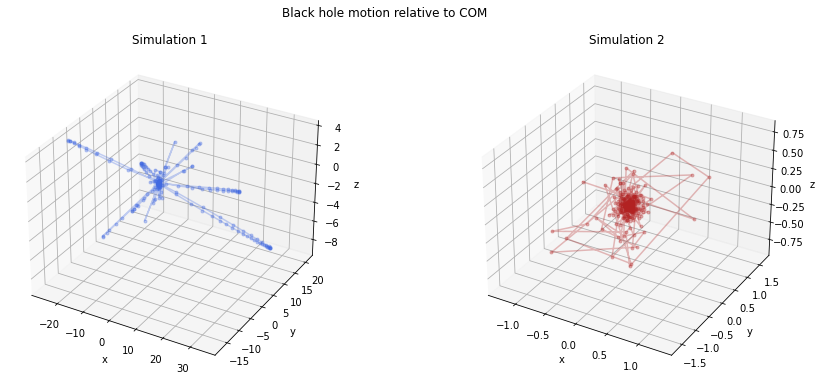

In [36]:
fig_bh_trajectory, axs = subplots3d(1, 2, figsize=(15,6))
sns.axes_style("whitegrid")
fig_bh_trajectory.suptitle('Black hole motion relative to COM')
for i in axs:
    i.set_xlabel('x')
    i.set_ylabel('y')
    i.set_zlabel('z')

axs[0].set_title('Simulation 1')
axs[0].plot(rel_bh1['x'], rel_bh1['y'], rel_bh1['z'], marker='.', alpha=0.3, color=colors[0])

axs[1].set_title('Simulation 2')
axs[1].plot(rel_bh2['x'], rel_bh2['y'], rel_bh2['z'], marker='.', alpha=0.3, color=colors[1])

plt.show()

We can observe that, as it should, BH candidates spends most of their time close to the CM of the system.

In simulation 1, we can observe the particle in higher orbits, caused by collisions within the central cluster. However, after some time, the particle drops back towards orbits closer to the center of mass, losing energy in the process, likely transferring it to other particles in the system by means of collisions as it travels through the denser areas of the system.

This behaviour can better be observed by plotting the overall distance from CM as a function of time.

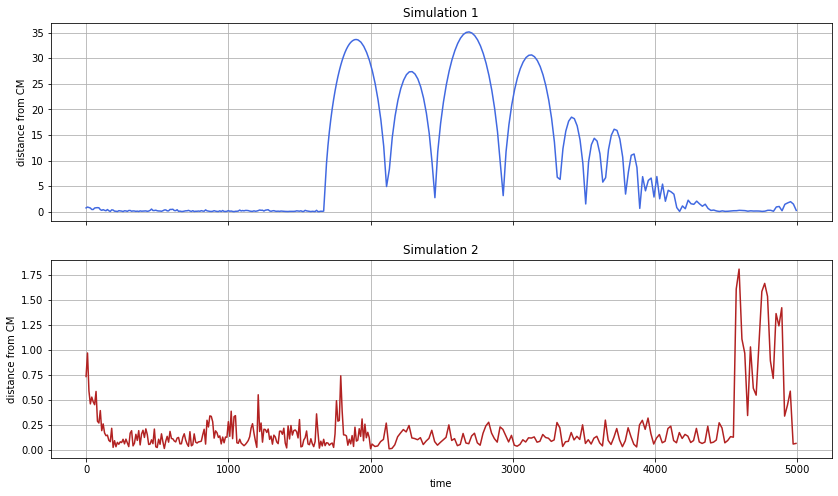

In [37]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=[14,8])

axs[0].set_title("Simulation 1")
axs[0].plot(rel_bh1["t"],rel_bh1["distance"], color=colors[0])
axs[0].set_ylabel("distance from CM")
axs[0].grid(True)

axs[1].set_title("Simulation 2")
axs[1].plot(rel_bh2["t"],rel_bh2["distance"], color=colors[1])
axs[1].set_xlabel("time")
axs[1].set_ylabel("distance from CM")
axs[1].grid(True)

plt.subplots_adjust(hspace=0.2)

In simulation 1, the particle stays close to the CM until around time $=1700$, when it gets dramatically knocked off course. It then orbits around the CM for some time, losing energy as it does, which we see as a reduction in the orbitting height. Eventually, it loses enough energy to return to its initial state, staying in close proximity of the CM.
In simulation 2, the particle is bound to the CM, remaining in close proximity at all times. Some collisions knock it momentarily into slightly higher orbits. 

This behaviour is consistent with the process of ejection of particles from the cluster.

The ejection phenomena can be seen as a limiting case of a jump to higher orbits, when a particle acquires enough energy to overcome the escape velocity. In our dataset, this happens due to high energy collisions, such as the one which makes the largest particle that remains in simulation 1, on track to escape.

### Statistical properties of IMBH candidates motion

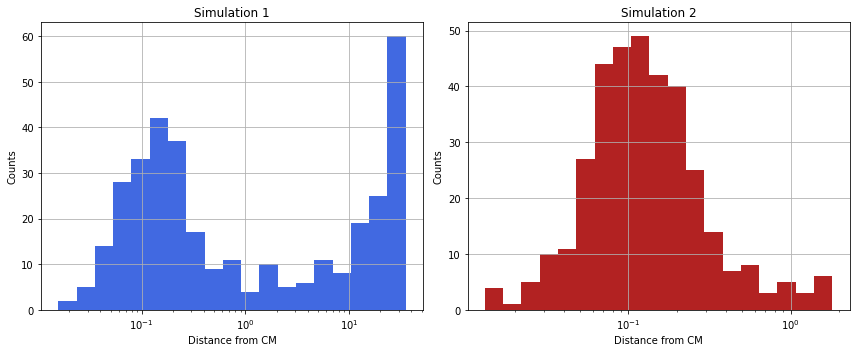

In [38]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
distances = [rel_bh1["distance"], rel_bh2["distance"]]
for i,ax in enumerate(axs):
    distances[i].hist(bins=np.logspace(np.log10(distances[i].min()), np.log10(distances[i].max()), 20), color=colors[i], ax=ax)
    ax.set_title("Simulation "+str(i+1))
    ax.set_xlabel("Distance from CM")
    ax.set_ylabel("Counts")
    ax.set_xscale("log")
fig.tight_layout()

We can observe in the distribution of distances from CM of the first simulation displays a bimodal shape. The shape of the distribution aroun the first peack (centered in 0.1) can be observed to be very much alike the distribution of the particle in the second simulation. This congruence signifies that the general motion of the particle around the CM in bot simulation has the same statistics, aside from occasional jumps. The "jump" state is represented in the first histogram by the second peak, in which are regrouped all the higher orbit positions. Since there are non significant jumps in the second simulation, this second peack is not present there.

### Filtering black hole data

In [39]:
filtered_bh1 = rel_bh1[rel_bh1['distance'] < 3]
filtered_bh2 = rel_bh2[rel_bh2['distance'] < 3]

coords = ['x', 'y', 'z']
directions = ['vx', 'vy', 'vz']

bh1_stats_posf = pd.DataFrame({'Std. dev': filtered_bh1[coords].std(), 'Skewness' : filtered_bh1[coords].skew(), 'Kurtosis' : filtered_bh1[coords].kurt()})
bh2_stats_posf = pd.DataFrame({'Std. dev': filtered_bh2[coords].std(), 'Skewness' : filtered_bh2[coords].skew(), 'Kurtosis' : filtered_bh2[coords].kurt()})

bh1_stats_velf = pd.DataFrame({'Std. dev': filtered_bh1[directions].std(), 'Skewness' : filtered_bh1[directions].skew(), 'Kurtosis' : filtered_bh1[directions].kurt()})
bh2_stats_velf = pd.DataFrame({'Std. dev': filtered_bh2[directions].std(), 'Skewness' : filtered_bh2[directions].skew(), 'Kurtosis' : filtered_bh2[directions].kurt()})

Upon applying the cut-off, the positions seem consistent between simulations, as shown by the similar measures of spread. Most of the motion close to the center of mass occurs within one unit of distance. Skewness varies slightly between directions, but its values are consistent with a mostly symmetric distribution. The larger values of kurtosis in the first simulation are likely due to the wider overall distance to the center of mass as the particle performs larger orbits.

### Truncated position data

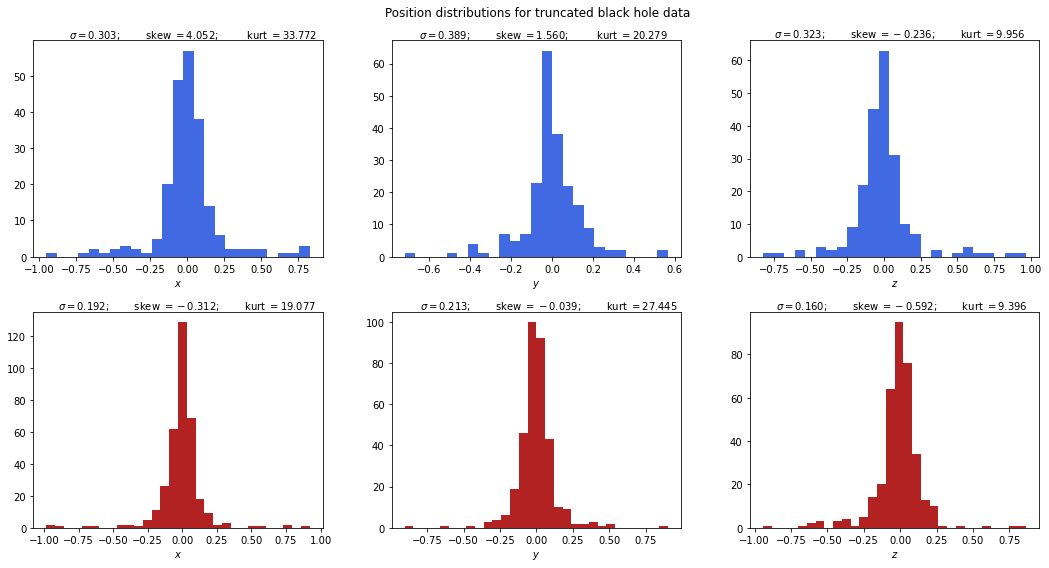

In [40]:
fig, axs = plt.subplots(2,3, figsize = (15,8))
axs = axs.flatten()
fig.suptitle('Position distributions for truncated black hole data')

axs[0].hist(filtered_bh1['x'][filtered_bh1['x'].abs() < 1], bins = 25, color=colors[0])
axs[0].set_xlabel('$x$')
axs[0].text(x = -.8, y = 60.5, s = '$\sigma = {:.3f}$; \t skew $= {:.3f}$; \t kurt $= {:.3f}$'.format(*[bh1_stats_posf.loc['x'][i] for i in bh1_stats_posf.columns]))

axs[1].hist(filtered_bh1['y'][filtered_bh1['y'].abs() < 1], bins = 25, color=colors[0])
axs[1].set_xlabel('$y$')
axs[1].text(x = -.65, y = 68, s = '$\sigma = {:.3f}$; \t skew $= {:.3f}$; \t kurt $= {:.3f}$'.format(*[bh1_stats_posf.loc['y'][i] for i in bh1_stats_posf.columns]))

axs[2].hist(filtered_bh1['z'][filtered_bh1['z'].abs() < 1], bins = 25, color=colors[0])
axs[2].set_xlabel('$z$')
axs[2].text(x = -.75, y = 67, s = '$\sigma = {:.3f}$; \t skew $= {:.3f}$; \t kurt $= {:.3f}$'.format(*[bh1_stats_posf.loc['z'][i] for i in bh1_stats_posf.columns]))

axs[3].hist(filtered_bh2['x'][filtered_bh2['x'].abs() < 1], bins = 30, color=colors[1])
axs[3].set_xlabel('$x$')
axs[3].text(x = -.9, y = 137, s = '$\sigma = {:.3f}$; \t skew $= {:.3f}$; \t kurt $= {:.3f}$'.format(*[bh2_stats_posf.loc['x'][i] for i in bh2_stats_posf.columns]))

axs[4].hist(filtered_bh2['y'][filtered_bh2['y'].abs() < 1], bins = 30, color=colors[1])
axs[4].set_xlabel('$y$')
axs[4].text(x = -.8, y = 106, s = '$\sigma = {:.3f}$; \t skew $= {:.3f}$; \t kurt $= {:.3f}$'.format(*[bh2_stats_posf.loc['y'][i] for i in bh2_stats_posf.columns]))

axs[5].hist(filtered_bh2['z'][filtered_bh2['z'].abs() < 1], bins = 30, color=colors[1])
axs[5].set_xlabel('$z$')
axs[5].text(x = -.85, y = 101, s = '$\sigma = {:.3f}$; \t skew $= {:.3f}$; \t kurt $= {:.3f}$'.format(*[bh2_stats_posf.loc['z'][i] for i in bh2_stats_posf.columns]))

fig.tight_layout(pad=1.0)
plt.show()

Upon applying the cut-off, the positions seem consistent between simulations, as shown by the similar measures of spread. Most of the motion close to the center of mass occurs within one unit of distance. Skewness varies slightly between directions, but its values are consistent with a mostly symmetric distribution. The larger values of kurtosis in the first simulation are likely due to the wider overall distance to the center of mass as the particle performs larger orbits.

### Complete velocity data

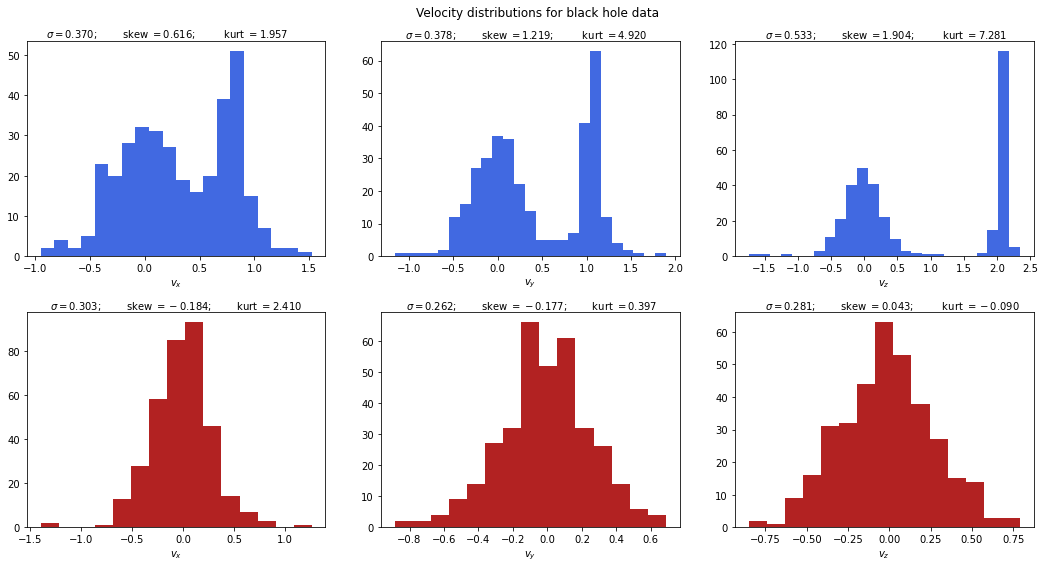

In [41]:
fig, axs = plt.subplots(2,3, figsize = (15,8))
axs = axs.flatten()
fig.suptitle('Velocity distributions for black hole data')

axs[0].hist(rel_bh1['vx'], bins = 20, color=colors[0])
axs[0].set_xlabel('$v_{x}$')
axs[0].text(x = -.9, y = 54.3, s = '$\sigma = {:.3f}$; \t skew $= {:.3f}$; \t kurt $= {:.3f}$'.format(*[bh1_stats_velf.loc['vx'][i] for i in bh1_stats_velf.columns]))

axs[1].hist(rel_bh1['vy'], bins = 25, color=colors[0])
axs[1].set_xlabel('$v_{y}$')
axs[1].text(x = -1.05, y  = 67, s = '$\sigma = {:.3f}$; \t skew $= {:.3f}$; \t kurt $= {:.3f}$'.format(*[bh1_stats_velf.loc['vy'][i] for i in bh1_stats_velf.columns]))

axs[2].hist(rel_bh1['vz'], bins = 25, color=colors[0])
axs[2].set_xlabel('$v_{z}$')
axs[2].text(x = -1.5, y = 123, s = '$\sigma = {:.3f}$; \t skew $= {:.3f}$; \t kurt $= {:.3f}$'.format(*[bh1_stats_velf.loc['vz'][i] for i in bh2_stats_velf.columns]))

axs[3].hist(rel_bh2['vx'], bins = 15, color=colors[1])
axs[3].set_xlabel('$v_{x}$')
axs[3].text(x = -1.3, y = 99, s = '$\sigma = {:.3f}$; \t skew $= {:.3f}$; \t kurt $= {:.3f}$'.format(*[bh2_stats_velf.loc['vx'][i] for i in bh2_stats_velf.columns]))

axs[4].hist(rel_bh2['vy'], bins = 15, color=colors[1])
axs[4].set_xlabel('$v_{y}$')
axs[4].text(x = -.82, y = 70, s = '$\sigma = {:.3f}$; \t skew $= {:.3f}$; \t kurt $= {:.3f}$'.format(*[bh2_stats_velf.loc['vy'][i] for i in bh2_stats_velf.columns]))

axs[5].hist(rel_bh2['vz'], bins = 15, color=colors[1])
axs[5].set_xlabel('$v_{z}$')
axs[5].text(x = -.75, y = 67, s = '$\sigma = {:.3f}$; \t skew $= {:.3f}$; \t kurt $= {:.3f}$'.format(*[bh2_stats_velf.loc['vz'][i] for i in bh2_stats_velf.columns]))

fig.tight_layout(pad=1.0)
plt.show()

The histograms of the velocities in simulation 2 are almost symmetric. This behaviour is consistent with a random-walk like motion, which is visible in the 3D trajectory plot.

Conversely, for simulation 1 we observe an asymmetric bimodal distribution. The peak centred around $0$ is compatible with the shape of the histograms in simulation 2 (the expected behaviour for random motion), while the other narrow peaks must be further discussed.
These can be explained by considering the orientation of the different orbital planes described by the particle.

An elliptical orbit would have a symmetric distribution of the velocities measured along the direction of the semi-major axis. However, the central body's location at one of the foci would in fact cause an asymmetry in the velocities measured in the direction of the semi-minor axis, as a consequence of conserved angular momentum. As is visible in the trajectory plot, most orbits' semi-major axes are parallel with the $x-y$-plane. This is reflected in the symmetry of the distributions in the $x$-direction, which is stronger than that along $y$. In any case, both of these are a significantly more symmetric than the distribution in the  $z$-direction. 

Not only that, but in the case of elliptical orbits, along the minor axis direction, a distribution with two asymmetric peaks would be expected, one positive and one negative. In the region of the perihelion the component of the velocity is high but there are just few counts, while in the region of the aphelion the component is low but there are many counts. However, because the perihelion lies inside the particle cluster, it is unlikely that any body would orbit without major precession caused by perturbations due to collisions occurring within the cluster. The significant effect of scattering would be behind the missing lower and farther peak of the distribution of the velocities.

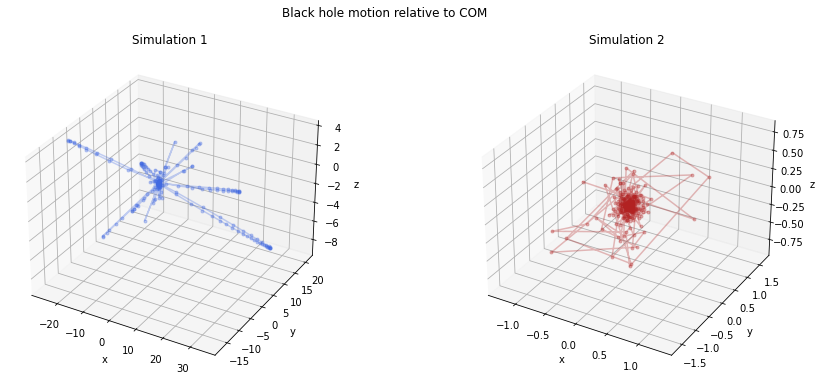

In [42]:
display(fig_bh_trajectory)

## Conclusions

We will summarise which steps were taken, and from them what results it is possible to draw. 

Initially, in order to get an understanding of the data, we plotted some sample snapshots to visualise the initial and final conditions. We then looked at the general trends, such as the total number of particles and the total mass. Plots of the evolution of the two show that the mass decreases faster than the particle number. From this simple graph we draw the logical conclusion that the particles which are ejected from the dataset are, on average, more massive than those which remain. This was explored further, and a plot showing the probability of ejection based on mass demonstrates that it was more probable that particles of higher mass would be ejected. Additionally, there were some anomolies in the dataset which could not be explained by physical phenomena and the dataset had to be fixed regarding these issues.

From there, we move on to the centre of mass, calculating it for each timestamp and plotting it's motion relative to the origin, in order to have some visual understanding of the data in the simulations. It, unexpectedly, displayed non-inertial motion. It displayed non-inertial motion due to recoil resulting from the ejection of some of the particles. We computed the centre of mass only on the core particles, in order to avoid the disproportional influence of the farthest particles.

We than enquired into the general properties of the relative position and velocities of the particles with respect to the COM. The relative behaviour of the particles in the simulation was found to be highly symmetric. Position and velocities where found to have very different distributions, the position distribution exibit lorenzian-like tails, while the velocity idistribution exibits gaussian-like tails. The mass density profiles where also analized, and a gas-like behaviour was inferred to take place within a range of roughly 0.1.

Moving to our search for an IMBH, several consideration led us to the conclusion that we have **no intermediate** massive black holes in our simulations, if anything we tracked some stellar mass black holes. Out of the two simulations, we studied the two most massive particles which survived inside the cluster until the end of the simulation. In both cases, we ended up studying Particle 44, which is the most massive particle that shows interesting behaviour.

We compared the histograms corresponding to the distributions of position and velocity in both simulations. For simulation 2 the distributions are consistent with a mostly random motion. On the contrary, for simulation 1, we could observe a mixed behaviour: when the particle lays inside the core of the cluster, an almost random motion is performed, while when the particles is thrown into large orbits the gravitational effect dominates.

To conclude, the analysis of these datasets has provided no evidence of the existence of an IMBH in any of the simulations. Still, we analysed the behaviour of the system and especially of the most massive particles, and we obtained that the motion of the particles is the superposition of two effects: the random motion due to the gravitational scattering among particles and the gravitational attraction towards the centre of the system.

Some points to consider for future investigations:

1. An IMBH in the dataset.
2. Properly define the turning point where the random behaviour dominates over the central gravitational attraction. Eventually, define a force field which models both these components, quantitatively.

## Bibliography

- **[1]** ["An intermediate-mass black hole in the centre of the globular cluster 47 Tucanae"](https://www.nature.com/articles/nature21361)  
Bülent Kızıltan, Holger Baumgardt, Abraham Loeb


- **[2]** ["An intermediate-mass black hole of over 500 solar masses in the galaxy ESO 243-49"](https://www.nature.com/articles/nature08083)  
Sean A. Farrell, Natalie A. Webb, Didier Barret, Olivier Godet, Joana M. Rodrigues


- **[3]** ["Revealing the intermediate-mass black hole at the heart of the dwarf galaxy NGC 404 with sub-parsec resolution ALMA observations"](https://arxiv.org/abs/2007.05536)  
Timothy A. Davis, Dieu D. Nguyen, Anil C. Seth, Jenny E. Greene, Kristina Nyland, Aaron J. Barth, Martin Bureau, Michele Cappellari, Mark den Brok, Satoru Iguchi, Federico Lelli, Lijie Liu, Nadine Neumayer, Eve V. North, Kyoko Onishi, Marc Sarzi, Mark D. Smith, Thomas G. Williams


- **[4]** ["Do intermediate-mass black holes exist?"](https://cordis.europa.eu/project/id/647208/it)  
Research project financed by CORDIS


- **[5]** ["Detectability of intermediate-mass black holes in multiband gravitational wave astronomy"](https://www.nature.com/articles/s41550-019-0932-7)  
Karan Jani, Deirdre Shoemaker, Curt Cutler


- **[6]** ["Searching for intermediate-mass black holes in galaxies with low-luminosity AGN: a multiple-method approach"](https://www.aanda.org/articles/aa/abs/2017/05/aa30061-16/aa30061-16.html)  
Filippos  Koliopanos, Bogdan C.  Ciambur, Alister W.  Graham, Natalie A.  Webb, Mickael  Coriat, Burçin  Mutlu-Pakdil, Benjamin L.  Davis, Olivier  Godet, Didier  Barret, Marc S. Seigar


- **[7]** ["An upper limit to the masses of stars"](https://arxiv.org/abs/astro-ph/0503193)  
Donald F. Figer


- **[8]** ["Intermediate-mass Black Holes in the Universe: A Review of Formation Theories and Observational Constraints"]()  
Roeland P. van der Marel